Spectroscopic data reduction in six
simple steps. The steps performed in this notebook are shown in **bold.**

**Step 1: Trim and subtract bias from all the data.** 

**Step 2: Flatfield the data.**

**Step 3: Construct a comparison lamp image from separate He and Ne lamps.**

Step 4: Fit a wavelength solution to the center of the lamp composite. 

Step 5: Extract the 1-D spectrum and its wavelength solution. 

Step 6: Apply a relative flux calibration. 

$\rightarrow$ now you are ready to do a bit of analysis.

Piece of cake. 

In [1]:
# start by importing the essentials 
import numpy as np 
from astropy.io import fits 
from matplotlib import pyplot as plt 

# (0) read in the data

### Arc Lamps: 

In [2]:
# a long exposure He lamp
he_i_long = fits.open('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/he_i_lowres_long.fits')

# a short exposure Ne/Ar lamp
ne_i_short = fits.open('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/ne_i_lowres_short.fits') 
# a long exposure Ne/Ar lamp
ne_i_long = fits.open('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/ne_i_lowres_long.fits') 

### Flats and Biases: 

In [3]:
# a flat field for the spectra
flat = fits.open('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/specflat.fits')

# a bias image with exposure time zero
bias = fits.open('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/specbias.fits')

### Darks: 

In [4]:
# these example data were taken with very short exposure times and therefore we don't have dark frames
# the RUCO CCD is not cryo-cooled, 
# so for longer integration times, we will absolutely need to subtract the dark current

### Science Targets: 

In [5]:
# Castor - a bright binary star with both components acquired
castor = fits.open('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/castor.fits')

# Beta CMi - a star with an interesting spectrum
betacmi = fits.open('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/betacmi.fits') 

### Flux calibrator: 

In [6]:
# Regulus is a spectral standard star with a known spectral energy distribution
regulus = fits.open('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/regulus.fits')

# (1) Trim and subtract bias from all the data. 

Except for setting the dispersion direction, these steps are the same as you do for an image. To start, display the long lamp spectrum of Ne/Ar. 

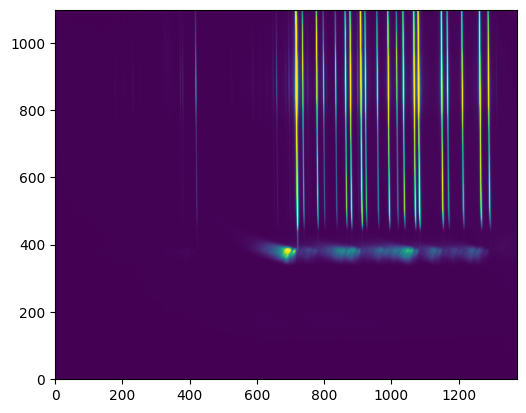

In [7]:
plt.imshow(ne_i_long[0].data, origin='lower')

The vertical lines are emission lines. These trace how wavelength maps to pixel space on the detector. Notice that the lines don't extend to the bottom of the detector; this marks the bottom of the slit. We’re only interested in the vertical region where lines are well-recorded. Decide on the range of y-values that you want to keep (keep all the x-values for now). 

In [8]:
# trim the images 
# lamps
lab2t_ne_long = ne_i_long[0].data[450:-10,:]
lab2t_ne_short = ne_i_short[0].data[450:-10,:]
lab2t_he_long = he_i_long[0].data[450:-10,:]

# flat 
lab2t_flat = flat[0].data[450:-10,:]

# regulus
lab2t_regulus = regulus[0].data[450:-10,:]

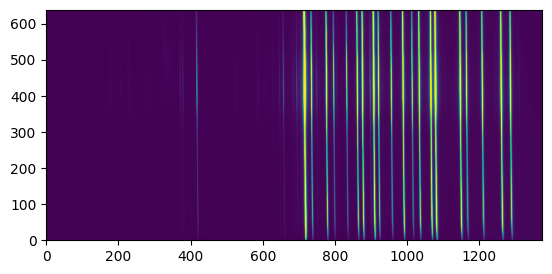

In [9]:
plt.imshow(lab2t_ne_long, origin='lower')

Trim all the calibration frames (lamps, bias, dark, flat), the science frames, and the flux calibrator. Recall from the imaging lab that all images need to be trimmed to the same size or you will not be able to process your data. 

Now subtract the bias:

In [10]:
lab2t_ne_long.shape

(639, 1374)

In [11]:
# lamps 
lab2tb_ne_long = lab2t_ne_long - bias[0].data[450:-10,:]
lab2tb_ne_short = lab2t_ne_short - bias[0].data[450:-10,:]
lab2tb_he_long = lab2t_he_long - bias[0].data[450:-10,:]

# regulus
lab2tb_regulus = lab2t_regulus - bias[0].data[450:-10,:]

Notice how the variable names are chose to keep track of the processing that has been done to the data. In this case, the variable name indicates that the data have been trimmed and bias subtracted. 

## (1.5) Subtract the dark current. 

Normally we’d want to take a dark frame with the same exposure time as the target and subtract that. But the stars in these example data are very bright, thus the exposure times were very short so the dark current is very low. So for this notebook, we'll only subtract the trimmed bias frame.

# (2) Flatfield the data. 

The flatfield images for spectroscopy serve the same purpose as for images: to correct for pixel-to-pixel variations. To see how different the flatfield looks for the spectroscopic data, first display the flat image. 

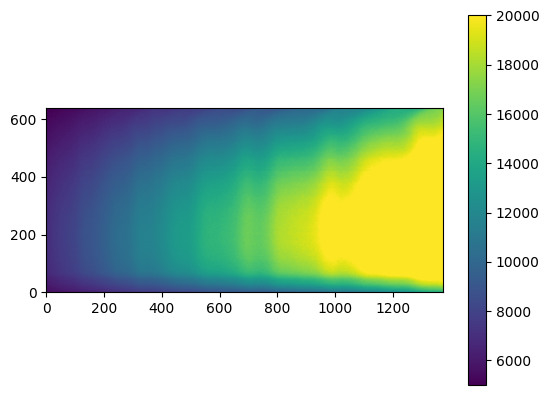

In [12]:
plt.imshow(lab2t_flat, origin='lower', vmin=5000, vmax=20000)
plt.colorbar()

Notice how much structure there is in the image (it's not very 'flat'). In this case, we are also getting a measure of how the system illuminates the CCD. We want to correct for this uneven response. To do this, we first want to normalize the flat so that its average value is ~1. 

In [13]:
norm_flat = lab2t_flat / np.median(lab2t_flat)
np.median(norm_flat)

1.0

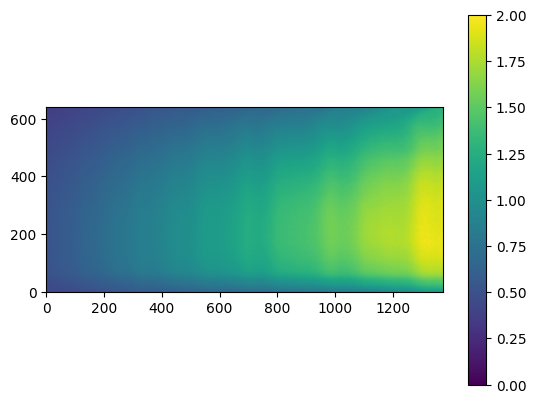

In [14]:
plt.imshow(norm_flat, origin='lower', vmin=0, vmax=2)
plt.colorbar()

Now simply divide the bias (and dark) subtracted spectra by this flat image. Be sure to give your flatfielded image a name that indicates that this step has been done. 

In [15]:
lab2f_regulus = lab2tb_regulus / norm_flat

### (3) Construct a comparison lamp image from separate He and Ne lamps for wavelength calibration.

Good wavelength calibrations require that we have lines we can identify across the entire spectral range - that is, across the entire spread of light on the CCD. The ideal wavelength calibration spectrum (or 'arc' for short) has enough counts for the fainter reference lines without saturating the bright lines. This is the same problem we saw with imaging - the CCD cannot record >65,000 counts. Saturated lines will look flat-topped in the trace of a saturated spectrum. 

Display the short and long Ne lamps, and the long He lamp either with python or in ds9. These spectra are taken with two different lamps: (1) the internal neon lamp that is built in to the instrument, and (2) a helium lamp that is outside the instrument that we have to hold up to the telescope. Fortunately, the neon lamp is contaminated with argon, so we get argon lines in the neon lamp (if only we had helium in there as well...). The Ne/Ar lamp has a lot of bright lines in the red half (right side) of the spectrum and fainter lines in most of the left side. The last 15% or so on the far left appears to be blank.

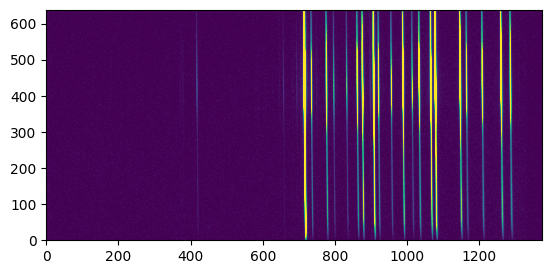

In [16]:
plt.imshow(lab2tb_ne_short, origin='lower', vmin=0, vmax=1250)

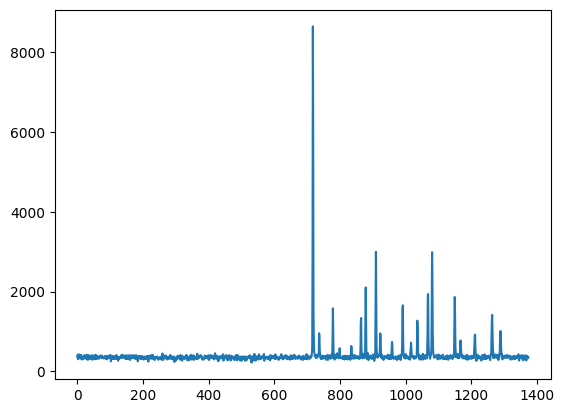

In [17]:
# take a slice across the image to look at the background level 
plt.plot(lab2t_ne_short[200,:])

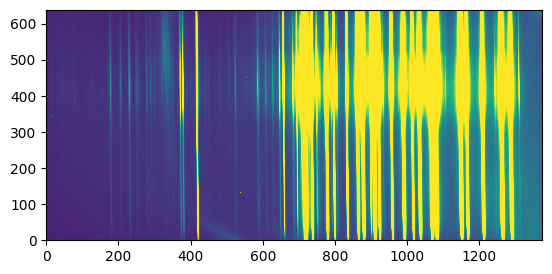

In [18]:
plt.imshow(lab2tb_ne_long, origin='lower', vmin=0, vmax=2500)

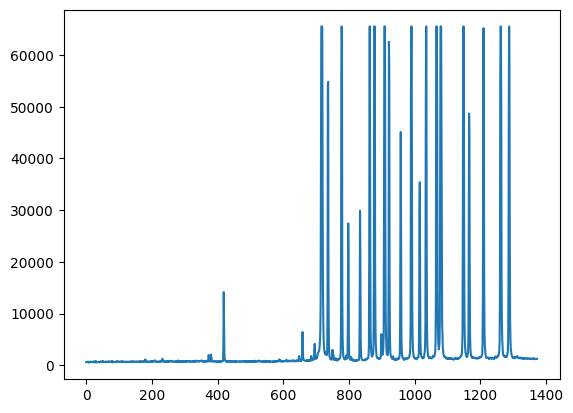

In [19]:
# take a slice across the image to look at the background level 
plt.plot(lab2t_ne_long[200,:])

In the short exposure, the brightest lines aren’t saturated but the faint lines are too noisy to use.

In the long long exposure, we get enough counts for the fainter Ne/Ar lines but the bright lines are saturated (note the peak intensity and flat-topped shape of the lines). 

To solve this issue, we’ll stitch together portions of each lamp spectrum where the data are good. 

Before we do so, we have to deal with a minor annoyance -- some scattered light in the long Ne lamp. Display 'lab2tb_long' and look at the values in portions of the spectrum where there is no line emission. Subtract out that continuum to make the inter-line regions near zero.

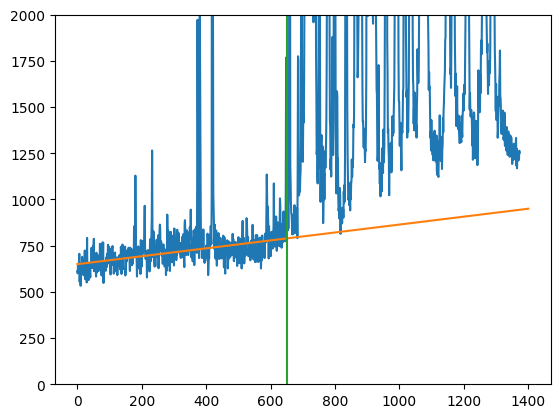

In [20]:
# zooming in to find the inter-line region and estimate the continuum to subtract 
plt.plot(lab2t_ne_long[200,:])
plt.ylim([0,2000])
plt.plot([0,1400],[650,950])
plt.plot([650,650],[0,2000])

In [21]:
# identify a mostly line-free region 
# determine the level and slope of the approximately linear continuum. 

m = (1400-950) / (650.)
b = 950 - m*650

ne_line = m*np.arange(len(lab2t_ne_long)) + b

In [22]:
# subtract this constant from the lamp 
lamp_spec = lab2t_ne_long - ne_line[:,np.newaxis]

Now we need to identify the portion of the spectrum where the lines are saturated (which we don't want) and where the lines are useable. We will substitute the short exposure where the lines in the long exposure are saturated. Let's stitch together the two exposures. 

In [23]:
lamp_spec[:,650:] = lab2tb_ne_short[:,650:]

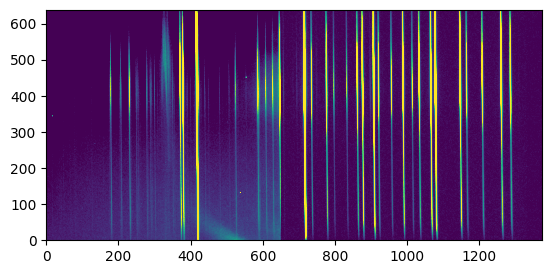

In [24]:
# take a look at the stitched together lamp file 
plt.imshow(lamp_spec, origin='lower', vmin=0, vmax=1000)

(0.0, 1000.0)

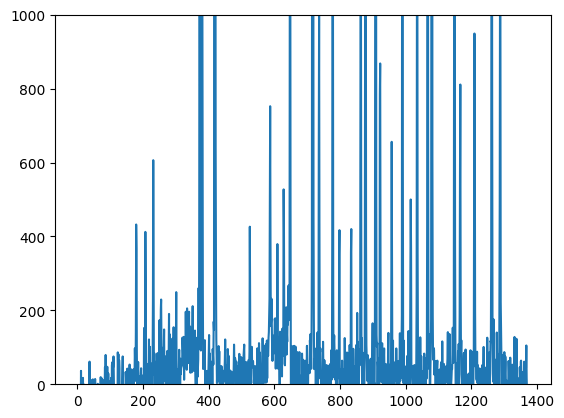

In [25]:
plt.plot(lamp_spec[300,:])
plt.ylim([0,1000])

Notice that the join isn't perfectly smooth. The background level in the composite doesn’t need to match perfectly because we are primarily interested in the location of the emission lines, but you don’t want it to be highly discontinuous where the frames are stitched together. 

We still have almost no lines in the bluest portion of the spectrum (far left). That is why we need the external helium lamp. Notice that there are several He lines in the blue portion of the spectrum as well as two really bright (read: saturated) ones in the red. Thankfully, we don't need the red lines because we have many Ne/Ar lines in the red potion of the spectrum. We’ll just add the useful blue lines to the composite lamp spectrum.

First, check to make sure the area between the lines in the long He lamp has approximately zero counts.

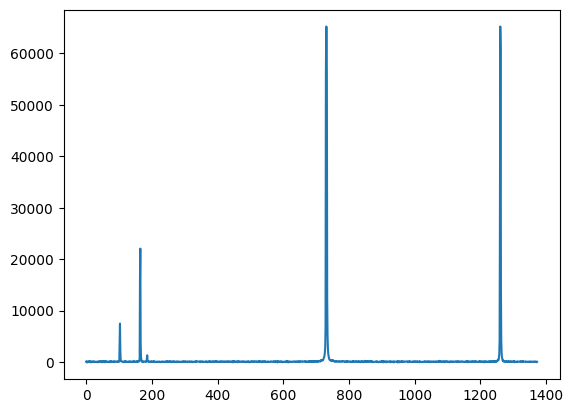

In [26]:
plt.plot(lab2tb_he_long[300,:])

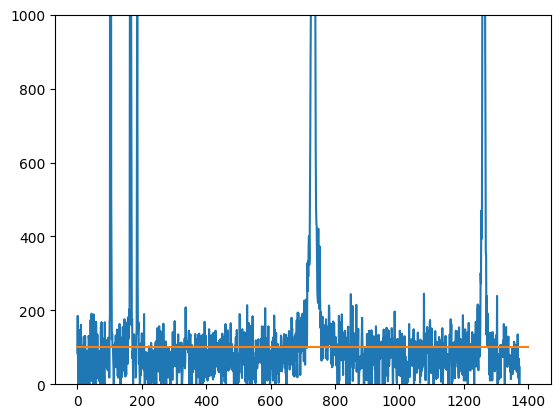

In [27]:
# zoom in to see how close to zero...
plt.plot(lab2tb_he_long[300,:])
plt.ylim([0,1000])
plt.plot([0,1400],[100,100])

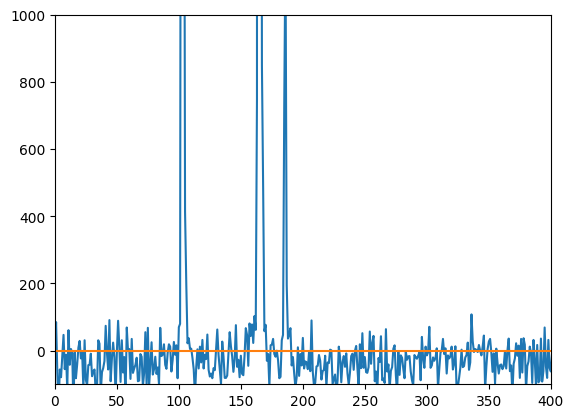

In [28]:
# zoom in to see how close to zero...
plt.plot(lab2tb_he_long[300,:]-100)
plt.ylim([-100,1000])
plt.xlim([0,400])
plt.plot([0,1400],[0,0])

Now we want to keep only the blue lines and set the rest of the array to zero so we can add the He lines to our composite spectrum.

In [29]:
# make a new array so we don't have to start over if we make a mistake 
blue_he_lines = lab2t_he_long - 400. 
# subtracting off a constant so the inter-line region is almost zero. 

In [30]:
# then set the red side of the array to zero
blue_he_lines[:,400:] = 0.

This should give us an image that is exactly or nearly zero everywhere except where there are the lines in the blue. Check to be sure this looks okay before adding it to the composite lamp spectrum. 

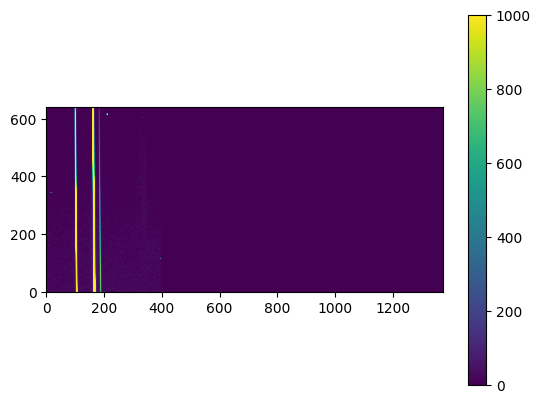

In [31]:
plt.imshow(blue_he_lines, origin='lower', vmin=0, vmax=1000)
plt.colorbar()

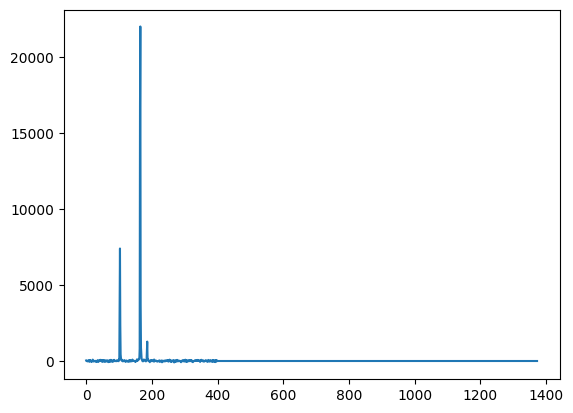

In [32]:
plt.plot(blue_he_lines[300,:])

If everything looks okay, add this to the composite lamp spectrum. 

In [33]:
lamp_spec += blue_he_lines

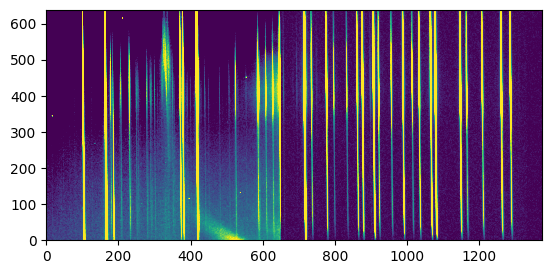

In [34]:
plt.imshow(lamp_spec, origin='lower', vmin=0, vmax=500)

(0.0, 1000.0)

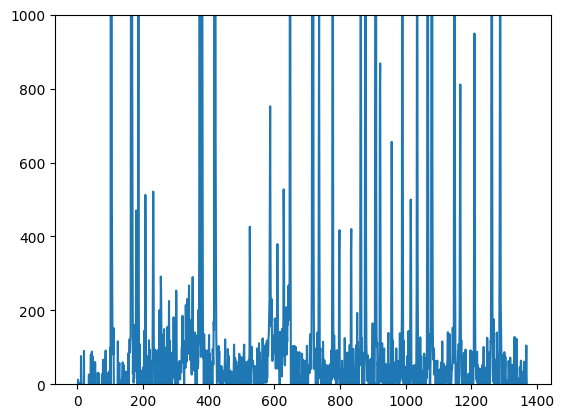

In [35]:
plt.plot(lamp_spec[300,:])
plt.ylim([0,1000])

Display your reduced lamp spectra and the composite lamp spectrum in different frames in ds9 and blink through them. The composite lamp spectrum should have a lot of lines but none that are saturated. We will use this composite spectrum for all wavelength calibrations.

In [36]:
fits.writeto('lamp_spec.fits', lamp_spec, overwrite=True)